In [1]:
import numpy as np
import time
from functools import wraps
from sage.all import *
from sage.numerical.mip import MIPSolverException
from sklearn.datasets import fetch_openml
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

2025-01-21 01:51:12.546032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 01:51:12.576821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 01:51:12.585400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 01:51:12.588261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 01:51:12.617960: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def timing_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"[TIME] {func.__name__} took {end - start:.3f} s")
        return result
    return wrapper

In [3]:
def load_mnist_data(N_samples=500, test_size=0.2, random_state=42):
    # Load the MNIST dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Optionally, combine train and test sets if you want to resplit
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    # Subsample if N_samples is less than the total number of samples
    if N_samples < len(X):
        rng = np.random.RandomState(random_state)
        idx = rng.choice(len(X), N_samples, replace=False)
        X = X[idx]
        y = y[idx]
    
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=float(test_size), random_state=random_state
    )
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_test = y_test.reshape(y_test.shape[0], -1)
    
    return X_train, X_test, y_train, y_test

def preprocess_data(X_train, X_test, pca_dims=5):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    if pca_dims > 0:
        pca = PCA(n_components=pca_dims)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca  = pca.transform(X_test_scaled)
    else:
        # if pca_dims=0, skip PCA
        X_train_pca = X_train_scaled
        X_test_pca  = X_test_scaled
        pca = None

    return X_train_pca, X_test_pca, scaler, pca

In [4]:
def generate_exponents(d, n):
    """
    Generates all tuples (a_1,...,a_d) of non-negative integers
    with a_1+...+a_d <= n.
    """
    # Simple recursive or iterative approach
    # For example, if d=2, n=2: (0,0), (1,0), (0,1), (2,0), (1,1), (0,2)
    # We'll do a small recursive generator:
    def recurse(dim, maxdeg, current):
        if dim==0:
            yield tuple(current)
        else:
            # we can put up to maxdeg in position 0..n
            for a in range(maxdeg+1):
                # next dimension can have up to leftover
                curr_copy = current[:]
                curr_copy.append(a)
                yield from recurse(dim-1, maxdeg, curr_copy)
    # That yields all combos a_1..a_d each in [0..n], sum not constrained
    # We need to filter sum(a_j)<=n
    all_tuples = recurse(d, n, [])
    for t in all_tuples:
        if sum(t)<=n:
            yield t

In [5]:
def build_partial_poly_matrix(X, n):
    """
    Builds partial polynomial features up to total degree <= n
    for each row in X (shape: (N,d)).
    Returns: shape (N, #monomials).
    """
    N,d = X.shape
    exps = list(generate_exponents(d, n))
    # exps is a list of exponent tuples (a_1,...,a_d)
    # We'll build features of size (#exps).
    M = len(exps)
    mat = np.zeros((N, M), dtype=np.float64)

    for i in range(N):
        for j,(a_tuple) in enumerate(exps):
            # compute x_1^a1 * x_2^a2 * ...
            val = 1.0
            for dim_idx, alpha in enumerate(a_tuple):
                if alpha>0:
                    val *= (X[i, dim_idx] ** alpha)
            mat[i,j] = val
    return mat, exps  # we return exps if we need to evaluate single points later

In [6]:
@timing_decorator
def solve_minmax_p(Xp, Xq, f_values, q_coeffs, z_bound=1.0):
    """
    Solve for p-coeffs in a min-max sense, with q fixed.
    We do: |f_i - p(x_i)/q(x_i)| <= z_bound
    => (f_i - z_bound)*q_i <= p_i <= (f_i + z_bound)*q_i
    => We'll treat z_bound as known, or do a small bisection if needed.

    Here p(x_i) = Xp[i,:]^T p_coeffs
         q(x_i) = Xq[i,:]^T q_coeffs  (already known from previous iteration)
    """
    N = len(f_values)
    p_dim = Xp.shape[1]

    # We'll do a linear feasibility check for p_coeffs:
    p_lp = MixedIntegerLinearProgram(maximization=False, solver="GLPK")
    v = p_lp.new_variable(real=True)

    # For each i:
    # define p_i = sum_{k=0..p_dim-1} Xp[i,k]*v[k]
    # define q_i = sum_{r=0..q_dim-1} Xq[i,r]*q_coeffs[r] (this is known, no variable)
    # so constraints: p_i >= (f_i - z_bound)*q_i
    #                p_i <= (f_i + z_bound)*q_i
    for i in range(N):
        f_i = f_values[i]
        lhs_p = sum(Xp[i,k]*v[k] for k in range(p_dim))
        q_val = 0.0
        for r,c_val in enumerate(q_coeffs):
            q_val += c_val*Xq[i,r]

        p_lp.add_constraint(lhs_p - (f_i - z_bound)*q_val >= 0)
        p_lp.add_constraint(lhs_p - (f_i + z_bound)*q_val <= 0)

    # just solve feasibility
    try:
        p_lp.solve()
        p_sol = np.array([p_lp.get_values(v[k]) for k in range(p_dim)])
        return True, p_sol
    except MIPSolverException:
        return False, None


In [7]:
@timing_decorator
def solve_minmax_q(Xp, Xq, f_values, p_coeffs, z_bound=1.0, DLB=1e-3, DUB=1e3):
    """
    Solve for q-coeffs in a min-max sense, with p fixed.
    |f_i - p_i/q_i| <= z_bound
    => (f_i - z_bound)*q_i <= p_i <= (f_i + z_bound)*q_i
    => DLB <= q_i <= DUB
    We'll do a linear feasibility for q_coeffs if we fix p_i.

    p_i = Xp[i,:]^T p_coeffs (known)
    q_i = Xq[i,:]^T q_vars
    """
    N = len(f_values)
    q_dim = Xq.shape[1]

    q_lp = MixedIntegerLinearProgram(maximization=False, solver="GLPK")
    v = q_lp.new_variable(real=True)

    # Optionally fix e.g. q_0=1 => to avoid trivial solutions
    # We demonstrate that approach:
    q_lp.add_constraint(v[0] == 1)

    for i in range(N):
        f_i = f_values[i]
        p_val = np.dot(p_coeffs, Xp[i,:])  # known
        lhs_q = sum(Xq[i,r]*v[r] for r in range(q_dim))

        q_lp.add_constraint( p_val - (f_i - z_bound)*lhs_q >= 0 )
        q_lp.add_constraint( p_val - (f_i + z_bound)*lhs_q <= 0 )
        # DLB <= lhs_q <= DUB
        q_lp.add_constraint(lhs_q >= DLB)
        q_lp.add_constraint(lhs_q <= DUB)

    try:
        q_lp.solve()
        q_sol = np.array([q_lp.get_values(v[r]) for r in range(q_dim)])
        return True, q_sol
    except MIPSolverException:
        return False, None

In [8]:
@timing_decorator
def train_iterative_rational_oneclass(X, f_values, n_p=2, n_q=1,
                                      max_samples=300,
                                      max_iter=10,
                                      z_bound=0.5,
                                      DLB=1e-3, DUB=1e3):
    """
    X: (N, d) data for a single class,  f_values in {0,1}.
    We'll do partial polynomials for p, q up to total degrees n_p, n_q.

    Steps:
      1) Sub-sample if needed
      2) Build partial expansions Xp, Xq
      3) Initialize q(x)=1 => q_coeffs = [1,0,0...]
      4) Alternate solve for p, solve for q, for max_iter steps
      5) Return final p_coeffs, q_coeffs
    """
    N = len(f_values)
    if max_samples < N:
        idx = np.random.choice(N, max_samples, replace=False)
        X_sub = X[idx]
        f_sub = f_values[idx]
    else:
        X_sub = X
        f_sub = f_values

    # Build expansions
    Xp, exps_p = build_partial_poly_matrix(X_sub, n_p)
    Xq, exps_q = build_partial_poly_matrix(X_sub, n_q)

    p_dim = Xp.shape[1]
    q_dim = Xq.shape[1]

    # init q_coeffs => fix q_0=1, rest=0
    q_coeffs = np.zeros(q_dim)
    q_coeffs[0] = 1.0

    # Iterative approach
    p_coeffs = np.zeros(p_dim)
    for it in range(max_iter):
        # Step A: Solve for p with q fixed
        feasible_p, p_new = solve_minmax_p(Xp, Xq, f_sub, q_coeffs, z_bound)
        if not feasible_p:
            print("No feasible p found in iteration", it)
            return None, None

        # Step B: Solve for q with p fixed
        feasible_q, q_new = solve_minmax_q(Xp, Xq, f_sub, p_new, z_bound, DLB, DUB)
        if not feasible_q:
            print("No feasible q found in iteration", it)
            return None, None

        p_coeffs = p_new
        q_coeffs = q_new

    # Done
    return p_coeffs, q_coeffs

In [9]:
def evaluate_point_rational(x, p_coeffs, q_coeffs, exps_p, exps_q):
    """
    Evaluate p(x)/q(x) at a single point x, given partial expansions exps_p, exps_q.
    """
    # Build partial polynomial for x in the same manner as build_partial_poly_matrix
    # We'll do a direct function for that:
    px = 1.0
    p_val = 0.0
    q_val = 0.0

    # For p:
    # p_val = sum_{j} p_coeffs[j] * x^{exps_p[j]}
    # We'll do it directly:
    monomials_p = 1.0
    p_val = 0.0
    for j, a_tuple in enumerate(exps_p):
        val = 1.0
        for dim_i, alpha in enumerate(a_tuple):
            if alpha>0:
                val *= x[dim_i]**alpha
        p_val += p_coeffs[j]*val

    # For q:
    monomials_q = 1.0
    q_val = 0.0
    for j, a_tuple in enumerate(exps_q):
        val = 1.0
        for dim_i, alpha in enumerate(a_tuple):
            if alpha>0:
                val *= x[dim_i]**alpha
        q_val += q_coeffs[j]*val

    if abs(q_val)<1e-12:
        return 1e9 if p_val>0 else -1e9
    return p_val/q_val

def predict_binary_approx(x, p_coeffs, q_coeffs, exps_p, exps_q, threshold=0.5):
    val = evaluate_point_rational(x, p_coeffs, q_coeffs, exps_p, exps_q)
    return 1 if val>threshold else 0

def accuracy_approx(X, f_values, p_coeffs, q_coeffs, exps_p, exps_q, threshold=0.5):
    correct=0
    for i in range(len(X)):
        pred = predict_binary_approx(X[i], p_coeffs, q_coeffs, exps_p, exps_q, threshold)
        if pred == f_values[i]:
            correct+=1
    return correct/len(X)

In [10]:
def train_ova_iterative(X_train, y_train, X_test, y_test,
                        n_p=2, n_q=1, pca_dims=5,
                        max_samples=300,
                        z_bound=0.5,
                        DLB=1e-3, DUB=1e3):
    """
    For digits [0..9], do:
      1) build f_c, in {0,1}
      2) train iterative approach => p_coeffs, q_coeffs
      3) store in models[c]
    Then test multi-class by picking the largest p_c(x)/q_c(x).

    Return (models, exps_p, exps_q).
    """
    # We'll do partial polynomial expansions in the original or PCA space
    # For demonstration, let's do a PCA outside this function if you want to.

    # Actually let's do it here for completeness
    # (But if you already have X_train_pca, just skip PCA here.)
    # We'll assume X_train, X_test are already scaled => optional
    # For clarity we skip PCA if pca_dims=0, or do it if > 0
    # *** If you do want to do it externally, just remove these lines.
    if pca_dims>0:
        scaler = StandardScaler()
        X_train_sc = scaler.fit_transform(X_train)
        X_test_sc  = scaler.transform(X_test)

        from sklearn.decomposition import PCA
        pca = PCA(n_components=pca_dims)
        X_train_pca = pca.fit_transform(X_train_sc)
        X_test_pca  = pca.transform(X_test_sc)
    else:
        X_train_pca = X_train
        X_test_pca  = X_test

    # We'll store: models[c] = (p_coeffs, q_coeffs, exps_p, exps_q)
    models = {}

    # Create per-class data
    for c in range(10):
        # f_c
        f_c = np.array([1 if lbl==c else 0 for lbl in y_train])

        # Train
        p_coeffs, q_coeffs = train_iterative_rational_oneclass(
            X_train_pca, f_c, n_p, n_q, max_samples=max_samples,
            z_bound=z_bound, DLB=DLB, DUB=DUB
        )
        if p_coeffs is None:
            print(f"Class {c} => No feasible solution.")
            models[c] = None
            continue

        # We'll keep expansions for p,q for evaluating new points:
        _, exps_p = build_partial_poly_matrix(X_train_pca[:1], n_p)
        _, exps_q = build_partial_poly_matrix(X_train_pca[:1], n_q)

        # Evaluate train accuracy quickly
        train_acc = accuracy_approx(X_train_pca, f_c, p_coeffs, q_coeffs, exps_p, exps_q)
        print(f"[OvA] Class {c}: train_acc={float(train_acc)}")

        models[c] = (p_coeffs, q_coeffs, exps_p, exps_q)

    # Evaluate multi-class on test
    test_preds = []
    for i in range(len(X_test_pca)):
        x = X_test_pca[i]
        best_class = None
        best_val   = -1e12
        for c in range(10):
            if models[c] is None:
                continue
            pcf, qcf, ep, eq = models[c]
            val_c = evaluate_point_rational(x, pcf, qcf, ep, eq)
            if val_c>best_val:
                best_val=val_c
                best_class=c
        test_preds.append(best_class)

    test_acc = np.mean([test_preds[i]==y_test[i] for i in range(len(y_test))])
    print(f"\nFinal Multi-Class Test Accuracy: {float(test_acc)}")

    return models, (X_train_pca, X_test_pca), test_preds

In [11]:
# import matplotlib.pyplot as plt
# def show_image_with_prediction(X_test, y_test, pred_labels, index=0):
#     """
#     X_test: original shape (N, 784)
#     y_test: true digit labels
#     pred_labels: array of predicted labels from your model
#     index: which test image to show
#     """
#     img = X_test[index].reshape(28,28)
#     true_label = y_test[index]
#     pred_label = pred_labels[index]

#     plt.figure()
#     plt.imshow(img, cmap='gray')
#     plt.title(f"True: {true_label}, Pred: {pred_label}")
#     plt.axis('off')
#     plt.show()

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_test_results(X_test_original, y_test, predictions, start_index=50, end_index=70):
    """
    Visualize test results in a grid, showing the images, predicted labels,
    and ground truth labels.

    Parameters:
    -----------
    X_test_original : np.ndarray
        The original test images you want to display, shape (N, 784) or (N, 28, 28).
        If (N, 784), it will be reshaped to 28x28 for plotting.
    y_test : np.ndarray
        True labels of the test images, shape (N,).
    predictions : np.ndarray
        The predicted labels for the test images, shape (N,).
    start_index : int, optional
        The starting index of the images you want to visualize.
    end_index : int, optional
        The ending index (non-inclusive) of the images you want to visualize.
    """

    # Number of rows and columns for the grid
    num_images = end_index - start_index
    rows = int(np.ceil(num_images / 5))  # show 5 images per row
    cols = 5

    # Create a figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  # Flatten axes array for easier iteration

    # Iterate through the specified range
    for idx, ax in zip(range(start_index, end_index), axes):
        # Get the predicted and true labels
        predicted_digit = predictions[idx]
        true_digit = y_test[idx]

        # Get the image (reshape if necessary)
        # If X_test_original is (N, 784), reshape to (28, 28)
        img = X_test_original[idx].reshape(28, 28) if X_test_original[idx].size == 784 else X_test_original[idx]

        # Determine correctness
        if predicted_digit == true_digit:
            status = "correct ✔️"
        else:
            status = "wrong ✖️"
        
        # Plot the image
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {predicted_digit}, True: {true_digit}\n{status}")
        ax.axis("off")  # Hide axes for cleaner visuals

    # Turn off any leftover subplots if #images not multiple of 5
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


Train shape: (400, 784) Test shape: (100, 784)
[TIME] solve_minmax_p took 2.280 s
[TIME] solve_minmax_q took 0.231 s
[TIME] solve_minmax_p took 2.438 s
[TIME] solve_minmax_q took 0.246 s
[TIME] solve_minmax_p took 2.195 s
[TIME] solve_minmax_q took 0.228 s
[TIME] solve_minmax_p took 2.621 s
[TIME] solve_minmax_q took 0.229 s
[TIME] solve_minmax_p took 2.488 s
[TIME] solve_minmax_q took 0.247 s
[TIME] solve_minmax_p took 2.221 s
[TIME] solve_minmax_q took 0.226 s
[TIME] solve_minmax_p took 2.757 s
[TIME] solve_minmax_q took 0.226 s
[TIME] solve_minmax_p took 2.825 s
[TIME] solve_minmax_q took 0.231 s
[TIME] solve_minmax_p took 2.182 s
[TIME] solve_minmax_q took 0.225 s
[TIME] solve_minmax_p took 2.195 s
[TIME] solve_minmax_q took 0.225 s
[TIME] train_iterative_rational_oneclass took 27.663 s
[OvA] Class 0: train_acc=0.89
[TIME] solve_minmax_p took 2.100 s
[TIME] solve_minmax_q took 0.216 s
[TIME] solve_minmax_p took 2.097 s
[TIME] solve_minmax_q took 0.216 s
[TIME] solve_minmax_p took 2

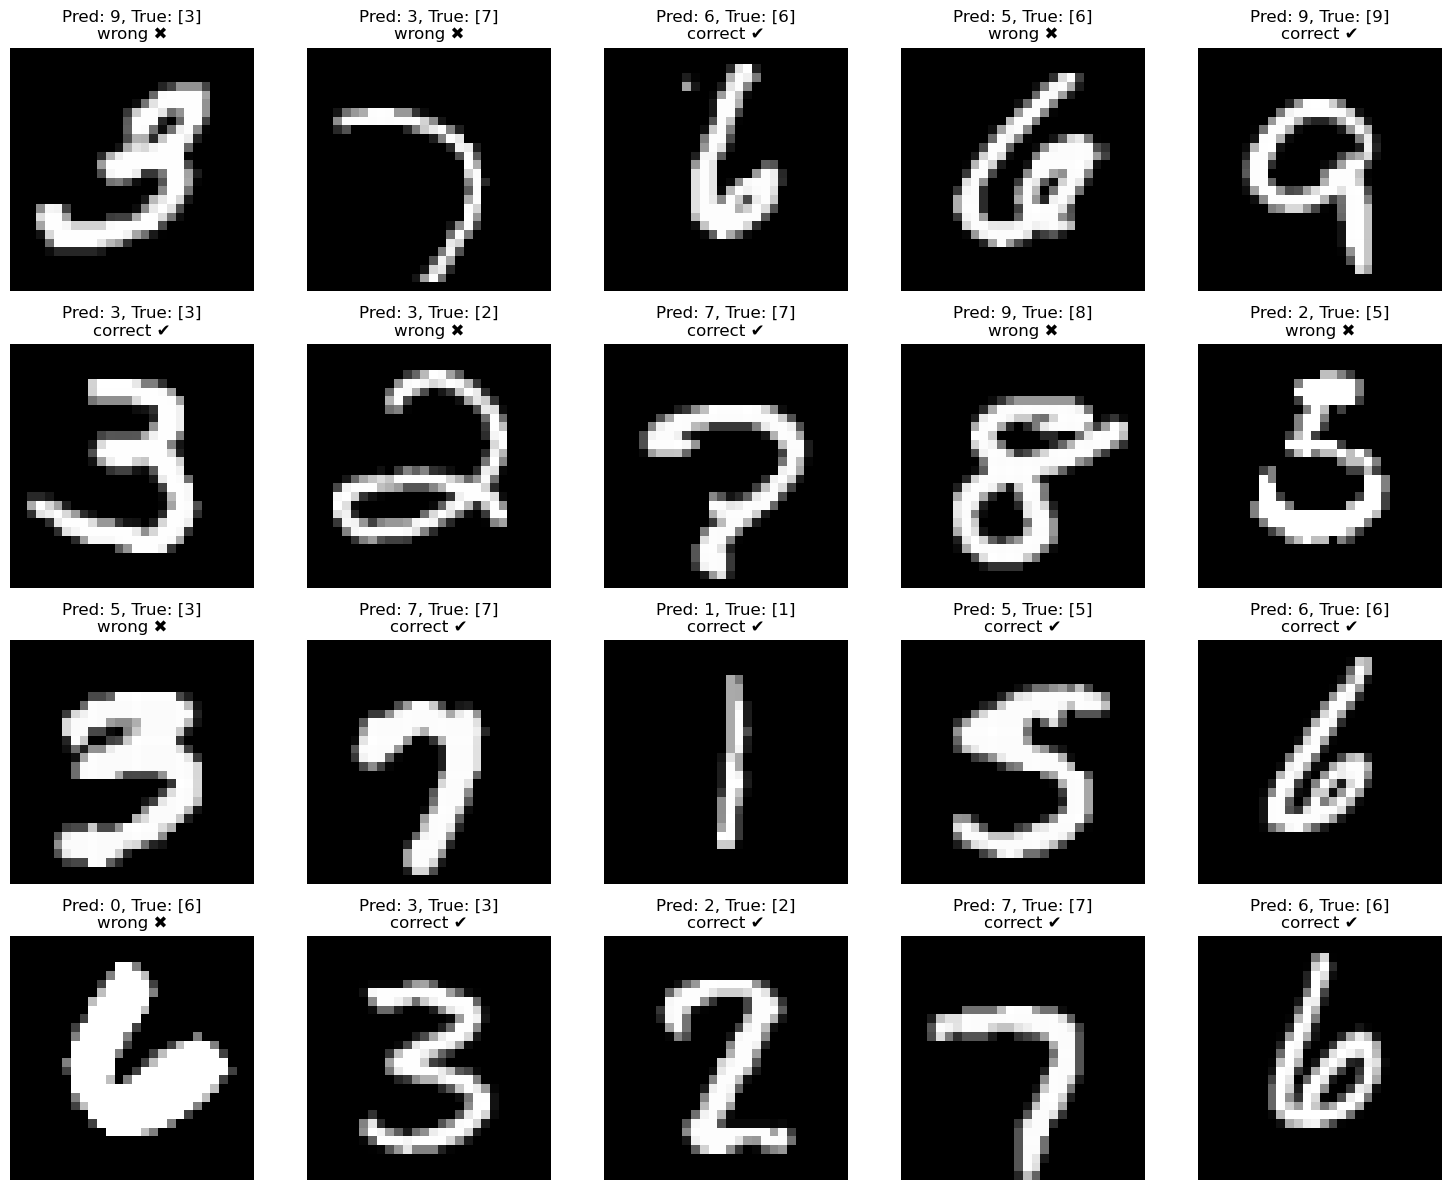

CPU times: user 4min 18s, sys: 1.08 s, total: 4min 19s
Wall time: 4min 19s


In [13]:
%%time
def main():
    # Load data
    X_train, X_test, y_train, y_test = load_mnist_data(N_samples=500, test_size=0.2)
    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    models, (X_train_pca, X_test_pca), test_preds = train_ova_iterative(
        X_train, y_train, X_test, y_test,
        n_p=4, n_q=2,
        pca_dims=7,
        max_samples=400,
        z_bound=0.5
    )
    # Suppose you have an array of predictions `preds` from your rational model
    # show_image_with_prediction(X_test, y_test, test_preds, index=25)
    visualize_test_results(
        X_test_original=X_test, 
        y_test=y_test, 
        predictions=test_preds,
        start_index=50,
        end_index=70
    )
if __name__=="__main__":
    main()